<a href="https://colab.research.google.com/github/costpetrides/Fluid-Dynamics/blob/main/2D-Cavity-Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Difference Method

We are using Navier-Stokes equations for an incompressible flow to simulate lid-driven cavity flow!

### Equations

1. **The Navier-Stokes equations for incompressible flow are:**

- **x-axis equation:**
\begin{equation}
  \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
\end{equation}

- **y-axis equation:**
\begin{equation}
  \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
\end{equation}


2. **Continuity equation (mass conservation):**
\begin{equation}
  \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
\end{equation}


### Numerical Discretization

We employed a finite difference method for spatial discretization and a forward difference for time. The pressure Poisson equation, derived from the continuity equation and momentum equations, is solved iteratively to ensure mass conservation.

### Boundary Conditions

For the lid-driven cavity flow, the boundary conditions are:

- **On the cavity walls (left, right, and bottom walls):**
\begin{equation}
  u = 0, \quad v = 0
\end{equation}

- **On the lid (top wall):**
\begin{equation}
  u = 1, \quad v = 0
\end{equation}

These conditions represent no-slip conditions on the walls, with the top wall moving at a constant velocity, driving the flow inside the cavity.

### Pressure Poisson Equation

The pressure Poisson equation, used to correct the pressure field ensuring incompressibility, is solved iteratively:

\begin{equation}
p_{i,j}^{n+1} = \frac{(p_{i+1,j}^n + p_{i-1,j}^n) \Delta y^2 + (p_{i,j+1}^n + p_{i,j-1}^n) \Delta x^2 - b_{i,j} \Delta x^2 \Delta y^2}{2(\Delta x^2 + \Delta y^2)}
\end{equation}

where \(b_{i,j}\) is computed from the velocity fields to reflect the divergence and changes over time, ensuring the continuity equation is satisfied!

Reynolds =  20.0


Text(0.5, 1.0, 'Stream Plot of Fluid Flow and Pressure Contours')

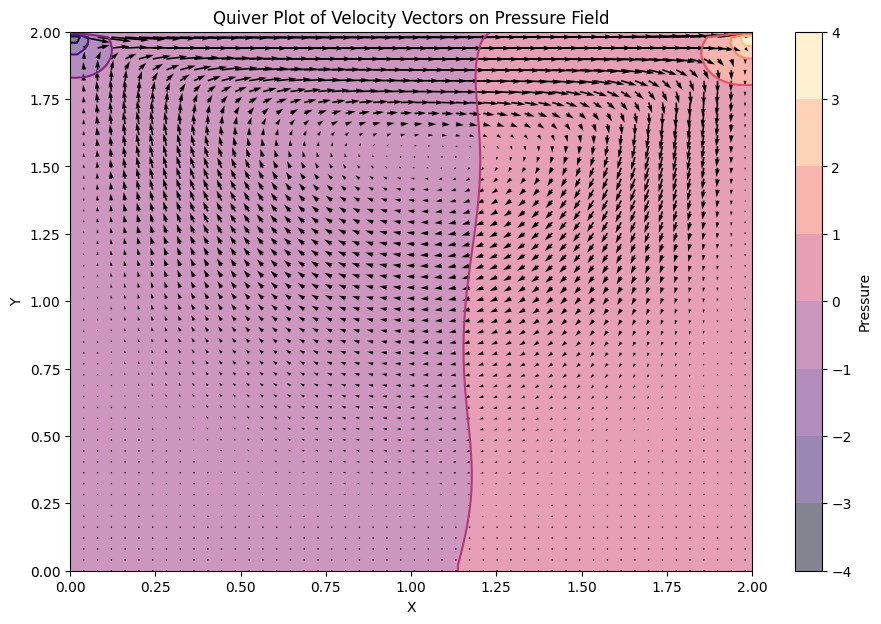

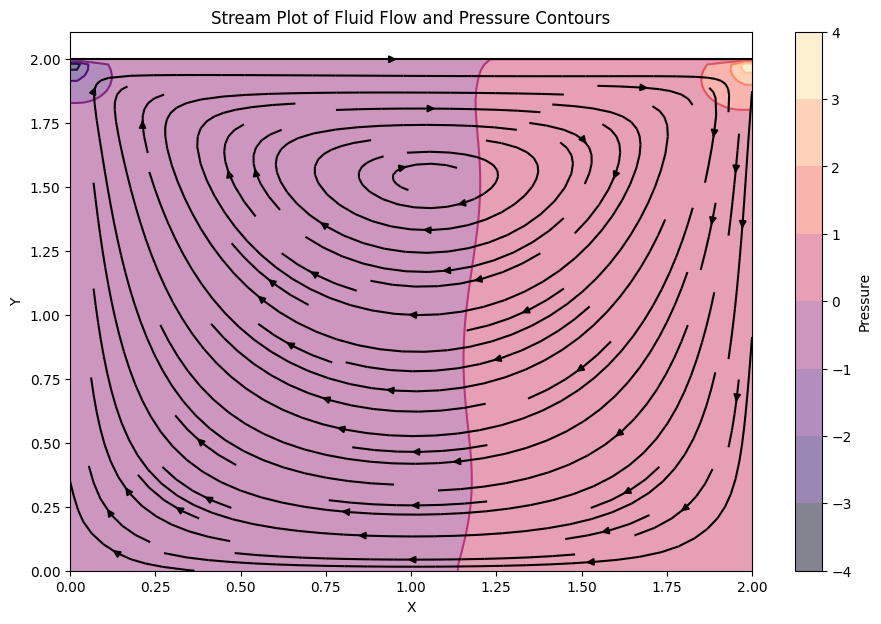

In [47]:
# Libraries we should need !
import numpy
from matplotlib import  cm
import matplotlib.pyplot as plt


# Parameters
nx = 100
ny = 100
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

# A helper method for momentum equation !
def build_up_b(b, rho, dt, u, v, dx, dy):

    b[1:-1, 1:-1] = (rho * (1 / dt *
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) /
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b


# Direct implementation of Poisson's
def pressure_poisson(p, dx, dy, b):
    pn = numpy.empty_like(p)
    pn = p.copy()

    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) *
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2

    return p

# Solves a discretized Navier Stokes in an iterative manner
# Initial condition set to simulate lid-driven cavity flow
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))

    for n in range(nt):
        un = u.copy()
        vn = v.copy()

        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)

        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0


    return u, v, p

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))

nt = 1000
rho = 1
nu = .1
dt = .001
print('Reynolds =  ' + str(rho*2/nu))
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)


# Quiverplot
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.magma)
plt.colorbar(label='Pressure')
plt.contour(X, Y, p, cmap=cm.magma)
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quiver Plot of Velocity Vectors on Pressure Field')


# Streamplot
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.magma)
plt.colorbar(label='Pressure')
plt.contour(X, Y, p, cmap=cm.magma)
plt.streamplot(X, Y, u, v, color='k')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Stream Plot of Fluid Flow and Pressure Contours')
